### __Tabular Model__

- スペクトログラムを作成

    https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html#feature-engineering

### __データ作成__

In [22]:
from utils import *

In [2]:
EXP_NAME = "exp08"
SEED = 42
N_SPLITS = 10

In [3]:
# データの読み込み
train_epochs = load_epoch("train")
test_epochs = load_epoch("test")

In [4]:
def epoch_to_sub_df(epoch, is_train):
    df = epoch.to_data_frame(verbose=False)
    new_meas_date = epoch.info["meas_date"].replace(tzinfo=None) + datetime.timedelta(seconds=epoch.info["temp"]["truncate_start_point"])
    
    df["meas_time"] = pd.date_range(start=new_meas_date, periods=len(df), freq=pd.Timedelta(1 / 100, unit="s"))
    df["meas_time"] = df["meas_time"].dt.hour * 60 + df["meas_time"].dt.minute # 時刻を分数に変換
    
    df["night"] = epoch.info["temp"]["night"]
    df["age"] = epoch.info["temp"]["age"]

    sex_map = {"male": 0, "female": 1}
    df["sex"] = epoch.info["temp"]["sex"]
    df["sex"] = df["sex"].map(sex_map)
    df["id"] = epoch.info["temp"]["id"]

    # 使用カラム
    cols = ["id", "meas_time", "Resp oro-nasal", "EMG submental", "Temp rectal", "Event marker", "night", "age", "sex"]
    
    # 訓練データにはアノテーション追加
    if is_train:
        cols.append("condition")

    df = df.loc[df.groupby("epoch")["time"].idxmin()].reset_index(drop=True)
    df = df[cols]
    
    return df

In [5]:
def power_band(epochs):
    channels = ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"]
    spectrum = epochs.compute_psd(picks=channels, verbose=False)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True) # 正規化

    X = []
    for i in range(len(channels)):
        for j in range(int(freqs[-1])):
            psds_band_mean = psds[:, i, (freqs >= j) & (freqs < j+1)].mean(axis=-1)
            X.append(psds_band_mean.reshape(len(psds), -1))

    # 脳波2チャンネルに渡る平均
    for j in range(int(freqs[-1])):
        psds_band_mean = psds[:, :2, (freqs >= j) & (freqs < j+1)].mean(axis=(1, 2))
        X.append(psds_band_mean.reshape(len(psds), -1))

    df = pd.DataFrame(np.concatenate(X, axis=1))
    df.columns = [f"{channel}_{str(i).zfill(2)}-{str(i+1).zfill(2)}" for channel in channels for i in range(50)] + [f"EEG_{str(i).zfill(2)}-{str(i+1).zfill(2)}" for i in range(50)]
    return df

In [6]:
train_df = []
for epoch in tqdm(train_epochs):
    sub_df = epoch_to_sub_df(epoch, is_train=True) # submission形式に変換
    feature_df = power_band(epoch) # スペクトログラム特徴量計算
    
    _df = pd.concat([sub_df, feature_df], axis=1)
    _df = _df[~_df["condition"].isin(["Sleep stage ?", "Movement time"])] # 不要なラベル除去
    
    train_df.append(_df)

train_df = pd.concat(train_df).reset_index(drop=True)
train_df["condition"] = train_df["condition"].map(LABEL2ID)

  0%|          | 0/108 [00:00<?, ?it/s]

In [7]:
test_df = []
for epoch in tqdm(test_epochs):
    sub_df = epoch_to_sub_df(epoch, is_train=False) # submission形式に変換
    feature_df = pd.DataFrame(power_band(epoch)) # スペクトログラム特徴量計算
        
    test_df.append(pd.concat([sub_df, feature_df], axis=1))
test_df = pd.concat(test_df)

  0%|          | 0/45 [00:00<?, ?it/s]

In [8]:
# シフト特徴量の作成
def make_shift(df, shift_columns):
    pre_df = df[shift_columns].shift(1).add_suffix("_pre")
    post_df = df[shift_columns].shift(-1).add_suffix("_post")
    return pd.concat([df, pre_df, post_df], axis=1)

shift_columns = train_df.drop(columns=["id", "meas_time", "night", "age", "sex", "condition"]).columns
train_df = make_shift(train_df, shift_columns)
test_df = make_shift(test_df, shift_columns)

### __学習__

- idでGroupKFold

    - ただしscikit-learnの`GroupKFold`は`random_state`が設定できないので`KFold`で実装

    - train: 80％ : valid: 20%

In [10]:
def custom_accuracy(y_pred, data):
    y_true = data.get_label()
    y_pred = y_pred.reshape(5, -1).argmax(axis=0)
    accuracy = accuracy_score(y_true, y_pred)
    return 'accuracy', accuracy, True

In [11]:
X = train_df.drop(columns=["id", "condition"])
y = train_df["condition"]
X_test = test_df.drop(columns=["id"])

params = {
    "boosting": "gbdt", # "gbdt"
    "objective": "multiclass", # 多クラス分類
    "seed": SEED,
    "num_leaves": 63,
    "learning_rate": 0.01,  # 学習率
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.8,
    'num_class': 5, # クラス数
}

cv_scores, results, models = [], [], []
test_prediction =  pd.DataFrame()
kf = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)
unique_ids = train_df["id"].unique()
for fold, (train_id_index, valid_id_index) in tqdm(enumerate(kf.split(unique_ids)), total=N_SPLITS):
    train_index =  train_df["id"].isin(unique_ids[train_id_index])
    valid_index =  train_df["id"].isin(unique_ids[valid_id_index])

    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    result = {}
    model = lgb.train(
        params=params,
        train_set=lgb_train, # 学習データ
        valid_sets=[lgb_train, lgb_valid], # 検証データ
        valid_names=['train', 'valid'], # 学習経過で表示する名称
        num_boost_round=1000, # イテレーションの回数
        feval=custom_accuracy,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False), # アーリーストッピング
            lgb.callback.record_evaluation(result), # ログの記録
            lgb.log_evaluation(0), # ログの表示
        ],
    )
    results.append(result)
    models.append(model)        

    score = result["valid"]["accuracy"][-1]
    cv_scores.append(score)
    print(f'Fold: {fold+1}  Accuracy: {score}')

    # 推論
    test_prediction[str(fold)] = model.predict(X_test).argmax(axis=1)
print(f"CV Score {np.mean(cv_scores)}")

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.590857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156348
[LightGBM] [Info] Number of data points in the train set: 144761, number of used features: 616
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.958582
[LightGBM] [Info] Start training from score -1.238058
[LightGBM] [Info] Start training from score -2.451117
[LightGBM] [Info] Start training from score -2.191185
[LightGBM] [Info] Start training from score -0.776139
Fold: 1  Accuracy: 0.8731081963321266
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.782827 seconds.
You can set `force_col_wise=true` to remove the o

### __提出ファイルの作成__

In [12]:
sample_submission_df = pd.read_csv(SUBMISSION_DIR / "sample_submission.csv", parse_dates=[1])
sample_submission_df

,id,meas_time,condition
0,53c1555,1989-11-20 23:19:30,Sleep stage W
1,53c1555,1989-11-20 23:20:00,Sleep stage W
2,53c1555,1989-11-20 23:20:30,Sleep stage W
3,53c1555,1989-11-20 23:21:00,Sleep stage W
4,53c1555,1989-11-20 23:21:30,Sleep stage W
...,...,...,...
52291,9b444bb,1989-04-12 07:32:30,Sleep stage W
52292,9b444bb,1989-04-12 07:33:00,Sleep stage W
52293,9b444bb,1989-04-12 07:33:30,Sleep stage W
52294,9b444bb,1989-04-12 07:34:00,Sleep stage W


In [13]:
sample_submission_df["condition"] = test_prediction.mode(axis=1).iloc[:, 0].astype(int) # アンサンブル
sample_submission_df["condition"] = sample_submission_df["condition"].map(ID2LABEL)
sample_submission_df.to_csv(SUBMISSION_DIR / f"{EXP_NAME}.csv", index=False)
sample_submission_df

,id,meas_time,condition
0,53c1555,1989-11-20 23:19:30,Sleep stage W
1,53c1555,1989-11-20 23:20:00,Sleep stage W
2,53c1555,1989-11-20 23:20:30,Sleep stage W
3,53c1555,1989-11-20 23:21:00,Sleep stage W
4,53c1555,1989-11-20 23:21:30,Sleep stage W
...,...,...,...
52291,9b444bb,1989-04-12 07:32:30,Sleep stage W
52292,9b444bb,1989-04-12 07:33:00,Sleep stage W
52293,9b444bb,1989-04-12 07:33:30,Sleep stage W
52294,9b444bb,1989-04-12 07:34:00,Sleep stage W


In [14]:
sample_submission_df["condition"].value_counts()

Sleep stage 2      21420
Sleep stage W      15844
Sleep stage R       6633
Sleep stage 1       4956
Sleep stage 3/4     3443
Name: condition, dtype: int64

### __学習曲線__

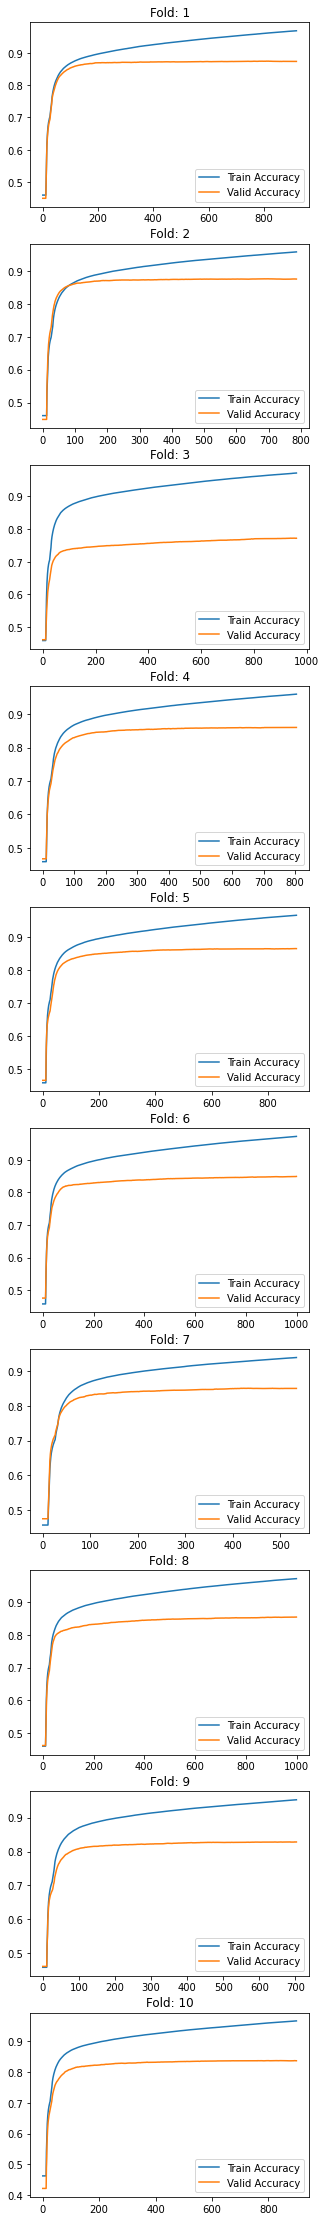

In [15]:
# fold毎に学習曲線を表示
plt.figure(figsize=(5, N_SPLITS*4))
for fold in range(N_SPLITS):
    plt.subplot(N_SPLITS, 1, fold+1)
    plt.plot(results[fold]['train']["accuracy"], label=f"Train Accuracy")
    plt.plot(results[fold]['valid']["accuracy"], label=f"Valid Accuracy")
    plt.title(f'Fold: {fold+1}')
    plt.legend()
plt.show()

### __特徴量の重要度__

In [16]:
importance = pd.DataFrame(np.mean([models[i].feature_importance(importance_type='gain') for i in range(N_SPLITS)], axis=0))
importance.columns = ['importance']
importance.index = X.columns
importance = importance.sort_values('importance', ascending=False)
importance /= importance["importance"].sum()
importance

,importance
EEG Pz-Oz_46-47,0.045056
EEG_45-46,0.042213
meas_time,0.035899
EEG Pz-Oz_02-03,0.023884
EEG_19-20,0.023442
...,...
EOG horizontal_24-25_post,0.000094
EEG Fpz-Cz_27-28_post,0.000093
EEG Fpz-Cz_35-36_post,0.000092
EEG Fpz-Cz_33-34_post,0.000086


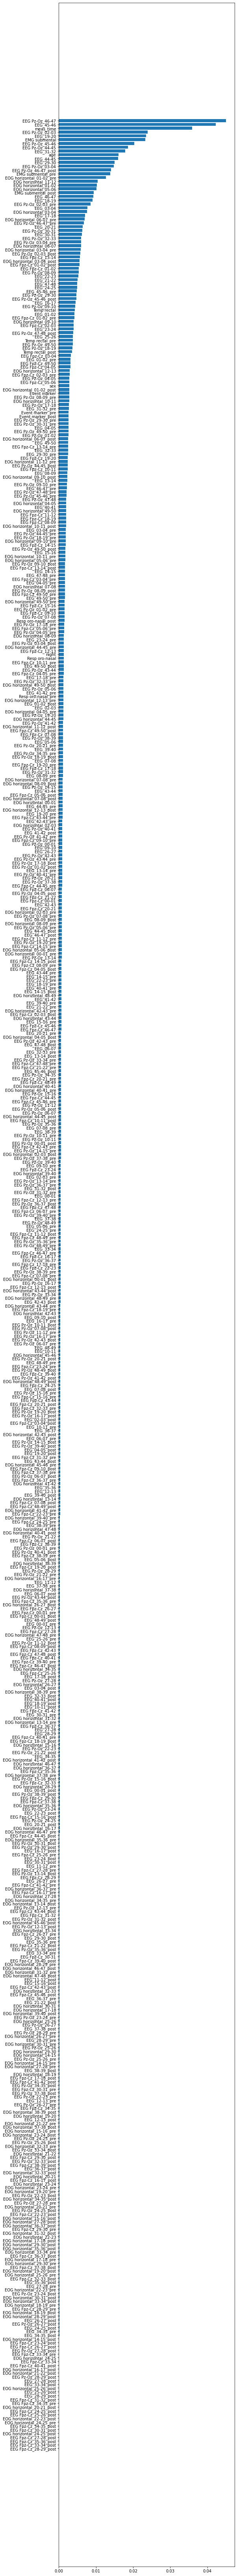

In [17]:
# 特徴量の重要度を可視化
plt.figure(figsize=(8, 40*3))
plt.barh(importance.index[::-1], importance.importance[::-1])
plt.savefig(DATA_DIR / f"importance_plot/{EXP_NAME}.jpg", dpi=200)
plt.show()

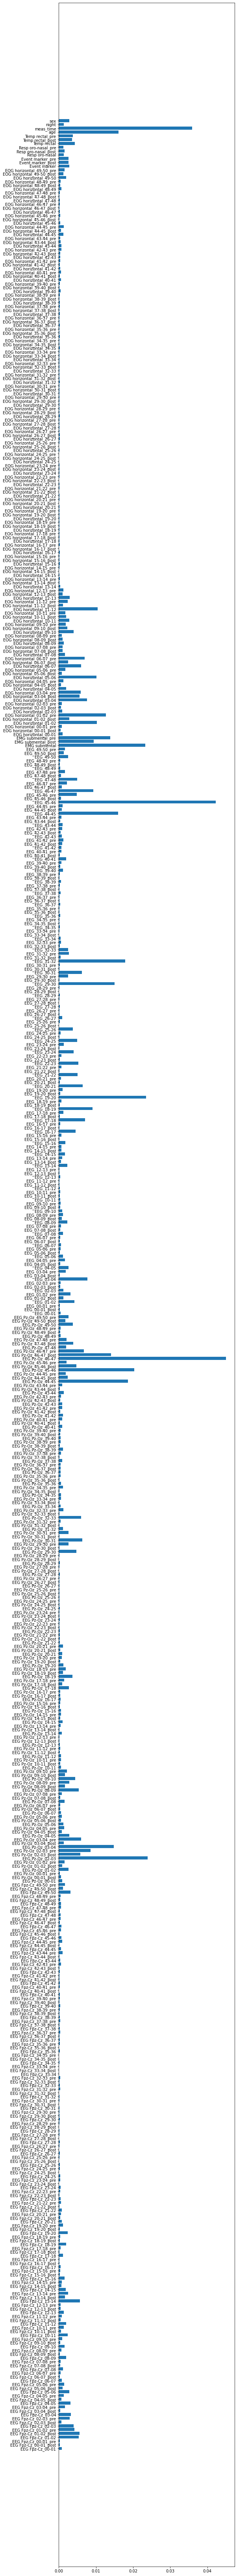

In [18]:
# indexでソートして表示
sorted_importance = importance.sort_index()

plt.figure(figsize=(8, 40*3))
plt.barh(sorted_importance.index, sorted_importance.importance)
plt.savefig(DATA_DIR / f"importance_plot/{EXP_NAME}_sort_index.jpg", dpi=200)
plt.show()

### __精度検証__

In [26]:
valid_pred = pd.Series(np.zeros(len(train_df))).astype(int)
for fold, (train_id_index, valid_id_index) in tqdm(enumerate(kf.split(unique_ids)), total=N_SPLITS):
    valid_index =  train_df["id"].isin(unique_ids[valid_id_index])
    X_valid = X[valid_index]
    y_pred = models[fold].predict(X_valid)
    valid_pred[valid_index] = y_pred.argmax(axis=1)
valid_pred

  0%|          | 0/10 [00:00<?, ?it/s]

0         4
1         4
2         4
3         4
4         4
         ..
161605    2
161606    2
161607    1
161608    1
161609    1
Length: 161610, dtype: int64

In [27]:
cm_df = pd.DataFrame(confusion_matrix(train_df["condition"], valid_pred))
cm_df.index = cm_df.index.map(ID2LABEL)
cm_df.index.name = "Actual"
cm_df.columns = cm_df.columns.map(ID2LABEL)
cm_df.columns.name = "Predicted"
cm_df

Predicted,Sleep stage 3/4,Sleep stage 2,Sleep stage 1,Sleep stage R,Sleep stage W
Actual,,,,,
Sleep stage 3/4,5538,2806,21,4,148
Sleep stage 2,1753,40639,1855,1216,1555
Sleep stage 1,113,4078,5495,1133,3059
Sleep stage R,59,2271,1072,13512,1081
Sleep stage W,33,603,1618,298,71650


In [28]:
# クラスごとの正解率
y_true = train_df["condition"]
for k, v in ID2LABEL.items():
    if k != -1:
        print(v, accuracy_score(y_true[y_true==k], valid_pred[y_true==k]))

Sleep stage W 0.9656073960270612
Sleep stage R 0.7508752431230897
Sleep stage 1 0.39595042513330453
Sleep stage 2 0.8643285550214811
Sleep stage 3/4 0.6502289538569919
